In [3]:
# Reload modules automatically
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [4]:
import scipy
import numpy as np
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_scatter import scatter_add
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops
from src.graph_models.cba import CBA
from src.graph_models import create_graph_model
from collections import Counter
import matplotlib.pyplot as plt


In [5]:
def histplot_degree_distr(A, title="CORA", max_plot_deg=None):
    deg = np.sum(A, axis=1)
    max_deg = np.max(deg)
    print(f"Average Degree: {np.sum(deg) / deg.shape[0]:.2f}")
    print(f"Maximum Degree: {max_deg}")
    c = Counter(deg)
    ordered_c = [c[i] if i in c else 0 for i in range(max_deg+1)]
    fig, axs = plt.subplots(1, 1)
    #print(ordered_c)
    bins = [i for i in range(len(ordered_c)+1)] 
    #axs.hist(bins[:-1], bins, weights=ordered_c, color="blue", rwidth=0.7, alpha=0.5)
    axs.bar(bins[:-1], ordered_c, alpha=0.8)
    #counts, bins = np.histogram(deg)
    #axs.stairs(bins, counts)
    if max_plot_deg is not None:
        axs.set_xlim(left=0, right=max_plot_deg)
    axs.set_ylabel("Number of Nodes")
    axs.set_xlabel("Node Degree")
    axs.set_title(title)
    plt.show()

Average Degree: 3.97
Maximum Degree: 60


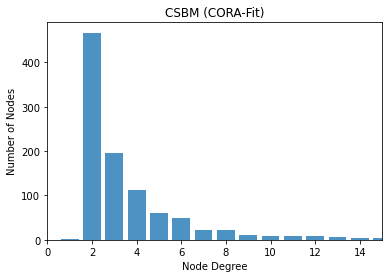

In [29]:
data_params = dict(
    graph_model = 'CBA',
    classes = 2,
    n = 1000,
    n_per_class_trn = 400,
    K = 2,
    sigma = 1,
    m=2,
    avg_within_class_degree = 1.58 * 2,
    avg_between_class_degree = 0.37 * 2,
    inductive_samples = 1000
)
graph_model = create_graph_model(data_params)
X_np, A_np, y_np = graph_model.sample(data_params["n"], 0)
histplot_degree_distr(A_np, max_plot_deg=15, title="CSBM (CORA-Fit)")

In [38]:
n_id = 1000
f_sep_y = 0
f_sep_n = 0
s_sep_y = 0
s_sep_n = 0
for i in range(1000):
    X, A, y = graph_model.sample_conditional(1, X_np, A_np, y_np)
    yes, no = graph_model.feature_separability(X, y, [n_id])
    f_sep_y += yes
    f_sep_n += no
    yes, no = graph_model.structure_separability(A, y, [n_id])
    s_sep_y += yes
    s_sep_n += no
print(f_sep_y, f_sep_n)
print(s_sep_y, s_sep_n)
    #graph_model.likelihood_separability(X, A, y, [n_id]))

824 176
806 194


In [24]:
data_params = dict(
    graph_model = 'CSBM',
    classes = 2,
    n = 1000,
    n_per_class_trn = 400,
    K = 2,
    sigma = 1,
    m=2,
    avg_within_class_degree = 1.58 * 2,
    avg_between_class_degree = 0.37 * 2,
    inductive_samples = 1000
)
graph_model = create_graph_model(data_params)
X_np, A_np, y_np = graph_model.sample(data_params["n"], 0)

-61.6149837502614

In [28]:
n_id = 1000
X, A, y = graph_model.sample_conditional(1, X_np, A_np, y_np)
graph_model.loglikelihood(n_id, y[n_id], X, A, y)

-54.06809646193423

In [16]:
n = 1000
n_intra_edges = 0
n_inter_edges = 0
for i in range(n):
    for j in range(i+1, n):
        if y_np[i] == y_np[j]:
            if A_np[i,j] == 1:
                 n_intra_edges += 1
        else:
            if A_np[i,j] == 1:
                 n_inter_edges += 1
print(f"Number of edges: {n_intra_edges + n_inter_edges}")
print(f"Average #edges per node: {(n_intra_edges + n_inter_edges)*2/n}")
print(f"Average intra-connections per node: {n_intra_edges *2/ n}")
print(f"Average inter-connections per node: {n_inter_edges *2/ n}")

Number of edges: 1983
Average #edges per node: 3.966
Average intra-connections per node: 3.166
Average inter-connections per node: 0.8


In [ ]:
data_params = dict(
    graph_model = 'CSBM',
    classes = 2,
    n = 1000,
    n_per_class_trn = 400,
    K = 2,
    sigma = 1,
    avg_within_class_degree = 1.58 * 2,
    avg_between_class_degree = 0.37 * 2,
    inductive_samples = 1000
)
graph_model = create_graph_model(data_params)
X_np, A_np, y_np = graph_model.sample(data_params["n"], 0)
X = torch.tensor(X_np, dtype=torch.float32, device="cuda:0")
A = torch.tensor(A_np, dtype=torch.float32, device="cuda:0")
y = torch.tensor(y_np, device="cuda:0")
adj = SparseTensor.from_dense(A)
row, col, _ = adj.coo()
print(row)
print(col)
print(torch.stack((row, col), dim=0))
A.nonzero().t()

In [9]:
dataset = Planetoid(root='data', name='Cora')
X = dataset.data.x
y = dataset.data.y
edge_index = dataset.data.edge_index
print(edge_index)
edge_weight = torch.ones((edge_index.size(1), ), device=edge_index.device)
row, col = edge_index
deg = scatter_add(edge_weight, col, dim=0, dim_size=X.size(0))
print(deg)
print(float("inf"))
print(y.shape)
print(y.view(-1).shape)
#y = F.one_hot(y).to(torch.float)
#print(y.size())
print(F.one_hot(y).shape)
y_ = F.one_hot(y)
print(y_)
y_[[1,2]]
torch.zeros((3,3))

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])
tensor([3., 3., 5.,  ..., 1., 4., 4.])
inf
torch.Size([2708])
torch.Size([2708])
torch.Size([2708, 7])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [56]:
class GCN(MessagePassing):
    def __init__(self, in_channels, out_channels, aggr: str = "add", 
                 flow: str = "source_to_target"):
        super().__init__(aggr, flow)
        self.lin = Linear(in_channels, out_channels, bias=False)

    def forward(self, X, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=X.size(0))
        X = self.lin(X)
        return self.propagate(edge_index, X=X)

    def message(self, X_j):
        print(X_j.size())
        print(X_j[:10, :5])
        return X_j + 1

    def update(self, aggr_out, X_j):
        print(aggr_out.size())
        return aggr_out * 100

In [57]:
model = GCN(in_channels=dataset.data.x.size(1), out_channels=10)
model.forward(dataset.data.x, dataset.data.edge_index)

torch.Size([13264, 10])
tensor([[-0.0173,  0.0529,  0.0042,  0.0244,  0.1070],
        [-0.0173,  0.0529,  0.0042,  0.0244,  0.1070],
        [-0.0173,  0.0529,  0.0042,  0.0244,  0.1070],
        [-0.0072,  0.1087,  0.0614,  0.0283,  0.0275],
        [-0.0072,  0.1087,  0.0614,  0.0283,  0.0275],
        [-0.0072,  0.1087,  0.0614,  0.0283,  0.0275],
        [-0.0455,  0.0201, -0.0049,  0.0073,  0.0557],
        [-0.0455,  0.0201, -0.0049,  0.0073,  0.0557],
        [-0.0455,  0.0201, -0.0049,  0.0073,  0.0557],
        [-0.0455,  0.0201, -0.0049,  0.0073,  0.0557]],
       grad_fn=<SliceBackward0>)
torch.Size([2708, 10])


tensor([[389.7239, 412.7906, 429.0812,  ..., 420.3212, 393.5004, 410.1242],
        [389.2765, 397.4312, 409.7231,  ..., 387.7980, 379.2740, 417.0523],
        [600.7773, 623.2421, 602.2294,  ..., 606.1293, 593.8380, 614.5193],
        ...,
        [202.6021, 203.6831, 204.2789,  ..., 216.3896, 203.2019, 191.3758],
        [531.6699, 533.6844, 491.4141,  ..., 524.5166, 515.8243, 479.3176],
        [516.1280, 524.0164, 496.5078,  ..., 513.3365, 534.8948, 487.5916]],
       grad_fn=<MulBackward0>)